# Precipitation Nowcasting using Neural Networks

In this exercise, you are going to build a set of deep learning models on a real world task using PyTorch. PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with PyTorch ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- Two-Dimentional Convolution Neural Network (2D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed PyTorch with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours).

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfall in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

In [1]:
!nvidia-smi

Thu Mar 21 00:05:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8             10W /   80W |       7MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# For summarizing and visualizing models
!pip install torchinfo
!pip install torchviz

In [3]:
!pip install torchvision
!pip install tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbclassic nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

In [4]:
!pip install wandb

## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [5]:
!pip install python-dotenv

In [6]:
!wandb login

wandb: Currently logged in as: patrickchodev. Use `wandb login --relogin` to force relogin


In [7]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
# from tqdm.notebook import tqdm
from tqdm import tqdm

torch.__version__ # 1.10.0+cu111

'2.2.1+cu121'

## Loading the data
Get the data set by going [here](https://drive.google.com/file/d/1NWR22fVVE0tO2Q5EbaPPrRKPhUem-jbw/view?usp=sharing) and click add to drive.

In [8]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [9]:
# !tar -xvf '/content/gdrive/My Drive/nowcastingHWdataset.tar.gz'
! if [ ! -d "./dataset" ]; then tar -xvf './nowcastingHWdataset.tar.gz'; fi

# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [10]:
def read_data(months, data_dir='dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)

        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [11]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


**features**
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

# Three-Layer Feedforward Neural Networks

In [12]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_test_ff = x_test.reshape((-1, 5*5*3))
    y_test_ff = y_test.reshape((-1, 1))

    return x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)
(558575, 75) (558575, 1)


### TODO#1

Explain each line of code in the function preprocess_for_ff()

**Ans:** The function `preprocess_for_ff()` reshapes the input and output data for a feedforward neural network. It flattens the input data (`x_train`, `x_val`, `x_test`) into 2D arrays with shape `(number of samples, 5*5*3)`. It also reshapes the output data (`y_train`, `y_val`, `y_test`) into 2D arrays with shape `(number of samples, 1)`. This is done to match the input shape required by the feedforward neural network.

## Dataset

To prepare a DataLoader in order to feed data into the model, we need to create a `torch.utils.data.Dataset` object first. (Learn more about it [here](https://pytorch.org/docs/stable/data.html#map-style-datasets))

Dataset is a simple class that the DataLoader will get data from, most of its functionality comes from `__getitem__(self, index)` method, which will return a single data point (both input and label). In real world scenarios the method can do some other stuffs such as

1. Load images

If your input (x) are images. Oftentimes you won't be able to fit all the training images into your RAM. Thus, you should pass an array (or list) of image path into the dataloader, and the `__getitem__` will be the one who dynamically loads the actual image from the harddisk for you.

2. Data Normalization

Data normalization helps improve stability of training. Unnormalized data can cause gradients to explode. There are many variants of normalization, but in this notebook we will use either minmax or z-score (std) normalization. Read [this](https://developers.google.com/machine-learning/data-prep/transform/normalization) (or google) if you wish to learn more about data normalization.

3. Data Augmentation

In computer vision, you might want to apply small changes to the images you use in training (adjust brightness, contrast, rotation) so that the model will generalize better on unseen data. There are two kinds of augmentation: static and dynamic. Static augmentation will augment images and save to disk as a new dataset. On the other hand, rather than applying the change initially and use the same change on each image every epoch, dynamic augmentation will augment each data differently for each epoch. Note that augmentation is usually done on the CPU and you might be bounded by the CPU instead. PyTorch has a dedicated [documentation about data augmentation](https://pytorch.org/vision/master/transforms.html) if you want to know more.

In [13]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [14]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [15]:
normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


## DataLoader

DataLoader feeds data from our dataset into the model. We can freely customize batch size, data shuffle for each data split, and much more with DataLoader class. If you're curious about what can you do with PyTorch's DataLoader, you can check [this documentation](https://pytorch.org/docs/stable/data.html)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

## Loss Function

PyTorch has many loss functions readily available for use. We can also write our own custom loss function as well. But for now, we will use [PyTorch's built-in mean squared error loss ](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In [17]:
loss_fn = nn.MSELoss()

### TODO#2

Why is the loss MSE?

**Ans:** Since we're going to do a regression problem, where the goal is to predict continuous value. MSE is ofen used.

## Device

Unlike Tensorflow/Keras, PyTorch allows user to freely put any Tensor or objects (loss functions, models, optimizers, etc.) in CPU or GPU. By default, all objects created will be in CPU. In order to use GPU we will have to supply `device = torch.device("cuda")` into the objects to move it to GPU. You will usually see the syntax like `object.to(device)` for moving CPU object to GPU, or `o = Object(..., device=device)` to create the object in the GPU.

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

Below, the code for creating a 3-layers fully connected neural network in PyTorch is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [19]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

### TODO#3

What is the activation function in the final dense layer? and why? Do you think there is a better activation function for the final layer?

**Ans:** There is no activation function for final dense layer - I think it should not since we going to predict something which in range of (`-R`,`R`)

In [20]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

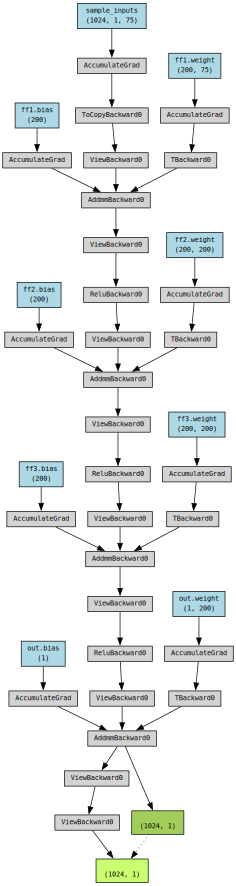

In [21]:
from torchviz import make_dot
# Visualize model with torchviz
sample_inputs = next(iter(train_loader))[0].requires_grad_(True)
sample_y = model_ff(sample_inputs.to(device))
make_dot(sample_y, params=dict(list(model_ff.named_parameters())+[('sample_inputs', sample_inputs)]))

In [22]:
summary(model_ff, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            [1024, 1]                 --
├─Linear: 1-1                            [1024, 200]               15,200
├─Linear: 1-2                            [1024, 200]               40,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

### TODO#4

Explain why the first linear layer has number of parameters = 15200

**Ans:**  The first linear layer has 15,200 parameters because it's calculated as (input_size * output_size) + output_size. Here, the input size is 75 and output size (hidden_size) is 200. So, (75 * 200) + 200 = 15200.

# Training

In [23]:
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: patrickchodev. Use `wandb login --relogin` to force relogin


Training epoch 1...
Current LR: 0.01


100%|██████████| 1121/1121 [00:51<00:00, 21.87it/s]


Epoch 1 train loss: 1.9290
Validating epoch 1


100%|██████████| 454/454 [00:20<00:00, 22.11it/s]


Epoch 1 val loss: 1.6611
Saving new best model..
Training epoch 2...
Current LR: 0.01


100%|██████████| 1121/1121 [00:52<00:00, 21.22it/s]


Epoch 2 train loss: 1.9235
Validating epoch 2


100%|██████████| 454/454 [00:19<00:00, 23.01it/s]


Epoch 2 val loss: 1.6601
Saving new best model..
Training epoch 3...
Current LR: 0.01


100%|██████████| 1121/1121 [00:53<00:00, 20.99it/s]


Epoch 3 train loss: 1.9235
Validating epoch 3


100%|██████████| 454/454 [00:20<00:00, 22.19it/s]


Epoch 3 val loss: 1.6639
Training epoch 4...
Current LR: 0.01


100%|██████████| 1121/1121 [00:51<00:00, 21.98it/s]


Epoch 4 train loss: 1.9235
Validating epoch 4


100%|██████████| 454/454 [00:19<00:00, 22.94it/s]


Epoch 4 val loss: 1.6603
Training epoch 5...
Current LR: 0.01


100%|██████████| 1121/1121 [00:51<00:00, 21.80it/s]


Epoch 5 train loss: 1.9234
Validating epoch 5


100%|██████████| 454/454 [00:20<00:00, 22.28it/s]


Epoch 5 val loss: 1.6628
Training epoch 6...
Current LR: 0.002


100%|██████████| 1121/1121 [00:51<00:00, 21.91it/s]


Epoch 6 train loss: 1.9233
Validating epoch 6


100%|██████████| 454/454 [00:19<00:00, 22.80it/s]


Epoch 6 val loss: 1.6618
Training epoch 7...
Current LR: 0.002


100%|██████████| 1121/1121 [00:51<00:00, 21.82it/s]


Epoch 7 train loss: 1.9233
Validating epoch 7


100%|██████████| 454/454 [00:20<00:00, 22.66it/s]


Epoch 7 val loss: 1.6610
Training epoch 8...
Current LR: 0.002


100%|██████████| 1121/1121 [00:51<00:00, 21.80it/s]


Epoch 8 train loss: 1.9233
Validating epoch 8


100%|██████████| 454/454 [00:19<00:00, 22.70it/s]


Epoch 8 val loss: 1.6616
Training epoch 9...
Current LR: 0.0004


100%|██████████| 1121/1121 [00:51<00:00, 21.80it/s]


Epoch 9 train loss: 1.9234
Validating epoch 9


100%|██████████| 454/454 [00:20<00:00, 22.42it/s]


Epoch 9 val loss: 1.6613
Training epoch 10...
Current LR: 0.0004


100%|██████████| 1121/1121 [00:51<00:00, 21.92it/s]


Epoch 10 train loss: 1.9234
Validating epoch 10


100%|██████████| 454/454 [00:19<00:00, 22.71it/s]


Epoch 10 val loss: 1.6613


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,█████▂▂▂▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▃▁█▁▆▄▃▄▃▃
lr,0.0004
train_loss,1.92336
val_loss,1.66132


Finished Training


### TODO#5

Plot loss and val_loss as a function of epochs.

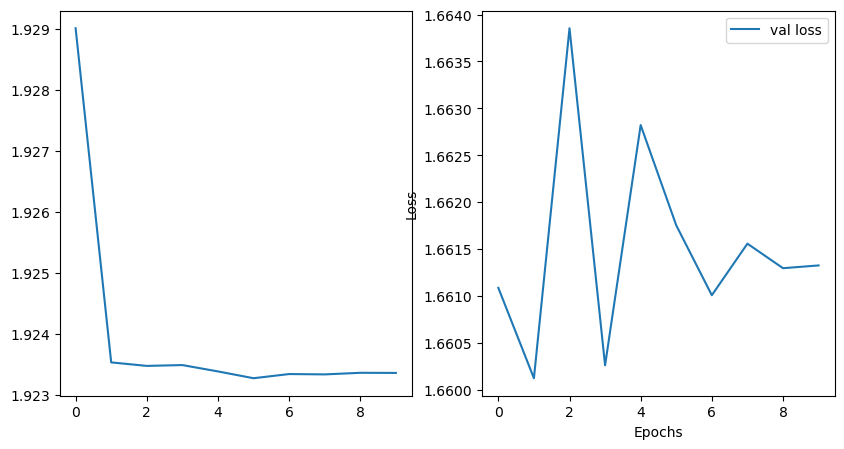

In [24]:
def plot_loss(train_losses, val_losses):
    plt.subplots(1,2,figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='train loss')
    plt.subplot(1,2,2)
    plt.plot(val_losses, label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(train_losses, val_losses)

### TODO#6

When does the model start to overfit?

**Ans:** epoch #4

### TODO#7

Plot the learning rate as a function of the epochs.

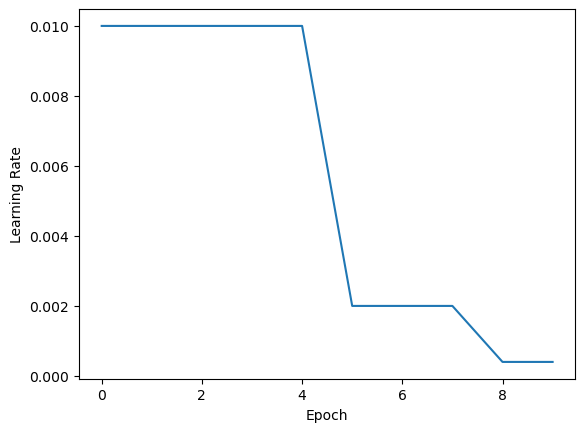

In [25]:
def plot_learning_rate(learning_rates):
    plt.plot(learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.show()
plot_learning_rate(learning_rates)

### TODO#8

What makes the learning rate change?
(hint: try to understand the scheduler [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html))


**Ans:** After epoch 3 to epoch 4 since the training loss is increasing

# Load Model

Use the code snippet below to load the model you just trained

In [26]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")

Loaded epoch 1 model


# A more complex scheduling

The scheduler can be very complicated and you can write your own heuristic for it.

### TODO#9

Implement a custom learning rate scheduler that behaves like the following graph.

You might want to learn how to use [PyTorch's built-in learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) in order to build your own.

Learning rate should be function of epoch.

![](https://raw.githubusercontent.com/pjumruspun/ComProg2021-Workshop/main/graph.png)

In [27]:
# Implement scheduler here
class MyScheduler():
    def __init__(self, optimizer: torch.optim.Optimizer):
        self.optimizer = optimizer
    
    def __step_cal(self,range_start,range_end,range_epoch,target_epoch):
        return range_start + (range_end - range_start) * (target_epoch / range_epoch)
    
    def state_dict(self):
        return self.optimizer.state_dict()

    def step(self, epoch):
        if epoch <= 3:
            self.optimizer.param_groups[0]['lr'] = self.__step_cal(1e-4,0.001,3,epoch)
        elif epoch <= 6:
            self.optimizer.param_groups[0]['lr'] = self.__step_cal(0.001,5e-4,3,epoch-3)
        elif epoch <= 7:
            self.optimizer.param_groups[0]['lr'] = self.__step_cal(5e-4,1e-3,1,epoch-6)
        else: 
            self.optimizer.param_groups[0]['lr'] = self.__step_cal(1e-3,1e-4,1,epoch-7)

In [28]:
model_ff_sched = FeedForwardNN(hidden_size=config['hidden_size']).to(device)

optimizer = torch.optim.Adam(model_ff_sched.parameters(), lr=1e-4)
scheduler = MyScheduler(optimizer)

train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff_sched, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    scheduler.step(epoch)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff_sched.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff_sched(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff_sched.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff_sched(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")


        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff_sched.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff_sched_custom_sched.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })
wandb.unwatch(model_ff_sched)
wandb.finish()
print('Finished Training')

Training epoch 1...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:51<00:00, 21.68it/s]


Epoch 1 train loss: 1.9195
Validating epoch 1


100%|██████████| 454/454 [00:20<00:00, 22.41it/s]


Epoch 1 val loss: 1.6576
Saving new best model..
Training epoch 2...
Current LR: 0.00039999999999999996


100%|██████████| 1121/1121 [00:52<00:00, 21.56it/s]


Epoch 2 train loss: 1.9187
Validating epoch 2


100%|██████████| 454/454 [00:20<00:00, 22.39it/s]


Epoch 2 val loss: 1.6564
Saving new best model..
Training epoch 3...
Current LR: 0.0007


100%|██████████| 1121/1121 [00:52<00:00, 21.46it/s]


Epoch 3 train loss: 1.9186
Validating epoch 3


100%|██████████| 454/454 [00:20<00:00, 22.23it/s]


Epoch 3 val loss: 1.6564
Saving new best model..
Training epoch 4...
Current LR: 0.001


100%|██████████| 1121/1121 [00:51<00:00, 21.71it/s]


Epoch 4 train loss: 1.9185
Validating epoch 4


100%|██████████| 454/454 [00:20<00:00, 22.18it/s]


Epoch 4 val loss: 1.6569
Training epoch 5...
Current LR: 0.0008333333333333334


100%|██████████| 1121/1121 [00:52<00:00, 21.33it/s]


Epoch 5 train loss: 1.9187
Validating epoch 5


100%|██████████| 454/454 [00:20<00:00, 22.51it/s]


Epoch 5 val loss: 1.6560
Saving new best model..
Training epoch 6...
Current LR: 0.0006666666666666668


100%|██████████| 1121/1121 [00:52<00:00, 21.19it/s]


Epoch 6 train loss: 1.9183
Validating epoch 6


100%|██████████| 454/454 [00:20<00:00, 22.11it/s]


Epoch 6 val loss: 1.6556
Saving new best model..
Training epoch 7...
Current LR: 0.0005


100%|██████████| 1121/1121 [00:52<00:00, 21.35it/s]


Epoch 7 train loss: 1.9177
Validating epoch 7


100%|██████████| 454/454 [00:20<00:00, 22.50it/s]


Epoch 7 val loss: 1.6567
Training epoch 8...
Current LR: 0.001


100%|██████████| 1121/1121 [00:52<00:00, 21.30it/s]


Epoch 8 train loss: 1.9181
Validating epoch 8


100%|██████████| 454/454 [00:20<00:00, 22.41it/s]


Epoch 8 val loss: 1.6559
Training epoch 9...
Current LR: 0.00010000000000000005


100%|██████████| 1121/1121 [00:52<00:00, 21.49it/s]


Epoch 9 train loss: 1.9173
Validating epoch 9


100%|██████████| 454/454 [00:20<00:00, 22.29it/s]


Epoch 9 val loss: 1.6558
Training epoch 10...
Current LR: -0.0007999999999999999


100%|██████████| 1121/1121 [00:52<00:00, 21.39it/s]


Epoch 10 train loss: 381417044622442496.0000
Validating epoch 10


100%|██████████| 454/454 [00:20<00:00, 22.22it/s]


Epoch 10 val loss: 3828582501043929088.0000


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,▄▆▇█▇▇▆█▄▁
train_loss,▁▁▁▁▁▁▁▁▁█
val_loss,▁▁▁▁▁▁▁▁▁█
lr,-0.0008
train_loss,3.814170446224425e+17
val_loss,3.828582501043929e+18


Finished Training


# [Optional] Wandb #

You should now have a project in wandb with the name `precipitation-nowcasting`, which you should see the latest run you just finished inside the project. If you look into the run, you should be able to see plots of learning rate, train loss, val loss in the `Charts` section. Below it should be `Gradients` and `Parameters` section.

# Wandb Observation #

### Optional TODO#1

Write your own interpretation of the logs from this example. A simple sentence or two for each section is sufficient.

**Your answer:** 

# Evaluation

In [29]:
################################################################################
# TODO#10:                                                                     #
# Write a function to evaluate your model. Your function must predicts         #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: Read how to use PyTorch's MSE Loss                                     #
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here

    mse = 0
    model.eval()
    loss_fn = nn.MSELoss()
    with torch.no_grad():
        for (inputs, y_true) in tqdm(data_loader):
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            y_pred = model(inputs)
            mse += loss_fn(y_pred, y_true).item()

    return mse / len(data_loader)

In [30]:
# We will use majority rule as a baseline.
def majority_baseline(label_set):
    unique, counts = np.unique(label_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    label_set = label_set.reshape(-1,1)
    for r in label_set:
        baseline += (majority - r) ** 2 / len(label_set)
    return baseline

In [31]:
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))

baseline


train [1.94397725]
validate [1.6746546]


In [38]:
print('FF-model')
print('train', evaluate(train_loader, model_ff))
print('validate', evaluate(val_loader, model_ff))

FF-model


 89%|████████▉ | 999/1121 [00:47<00:05, 21.23it/s]


AttributeError: 'NoneType' object has no attribute '_log'

# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

To access PyTorch's dropout, use `nn.Dropout`. Read more about PyTorch's built-in Dropout layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [39]:
################################################################################
# TODO#11:                                                                     #
# Write a feedforward model with dropout                                       #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class FeedForwardNNWithDropout(nn.Module):
    def __init__(self, hidden_size=200, dropout=0.2):
        super(FeedForwardNNWithDropout, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd1 = self.dropout(hd1)
        hd2 = F.relu(self.ff2(hd1))
        hd2 = self.dropout(hd2)
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)


In [40]:
################################################################################
# TODO#12:                                                                     #
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

model_ff = FeedForwardNNWithDropout(hidden_size=config['hidden_size']).to(device)

optimizer = torch.optim.Adam(model_ff.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff_with_dropout.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })
wandb.unwatch(model_ff)
wandb.finish()
print('Finished Training')

start training ff dropout


Training epoch 1...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:52<00:00, 21.40it/s]


Epoch 1 train loss: 1.9199
Validating epoch 1


100%|██████████| 454/454 [00:19<00:00, 23.41it/s]


Epoch 1 val loss: 1.6566
Saving new best model..
Training epoch 2...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:50<00:00, 22.17it/s]


Epoch 2 train loss: 1.9191
Validating epoch 2


100%|██████████| 454/454 [00:20<00:00, 21.76it/s]


Epoch 2 val loss: 1.6566
Training epoch 3...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:52<00:00, 21.23it/s]


Epoch 3 train loss: 1.9180
Validating epoch 3


100%|██████████| 454/454 [00:20<00:00, 22.03it/s]


Epoch 3 val loss: 1.6567
Training epoch 4...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:54<00:00, 20.43it/s]


Epoch 4 train loss: 1.9187
Validating epoch 4


100%|██████████| 454/454 [00:21<00:00, 20.94it/s]


Epoch 4 val loss: 1.6560
Saving new best model..
Training epoch 5...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:54<00:00, 20.56it/s]


Epoch 5 train loss: 1.9182
Validating epoch 5


100%|██████████| 454/454 [00:20<00:00, 21.71it/s]


Epoch 5 val loss: 1.6562
Training epoch 6...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:53<00:00, 21.15it/s]


Epoch 6 train loss: 1.9181
Validating epoch 6


100%|██████████| 454/454 [00:20<00:00, 21.74it/s]


Epoch 6 val loss: 1.6564
Training epoch 7...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:52<00:00, 21.27it/s]


Epoch 7 train loss: 1.9175
Validating epoch 7


100%|██████████| 454/454 [00:20<00:00, 21.68it/s]


Epoch 7 val loss: 1.6558
Saving new best model..
Training epoch 8...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:52<00:00, 21.26it/s]


Epoch 8 train loss: 1.9183
Validating epoch 8


100%|██████████| 454/454 [00:20<00:00, 22.02it/s]


Epoch 8 val loss: 1.6559
Training epoch 9...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:52<00:00, 21.24it/s]


Epoch 9 train loss: 1.9177
Validating epoch 9


100%|██████████| 454/454 [00:20<00:00, 21.73it/s]


Epoch 9 val loss: 1.6562
Training epoch 10...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:52<00:00, 21.24it/s]


Epoch 10 train loss: 1.9179
Validating epoch 10


100%|██████████| 454/454 [00:20<00:00, 22.13it/s]


Epoch 10 val loss: 1.6563


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▂▅▃▃▁▃▂▂
val_loss,▇██▂▅▆▁▂▄▅
lr,0.0001
train_loss,1.91787
val_loss,1.6563


Finished Training


### TODO#13

Plot the losses and MSE of the training and validation as before. Evaluate the dropout model's performance

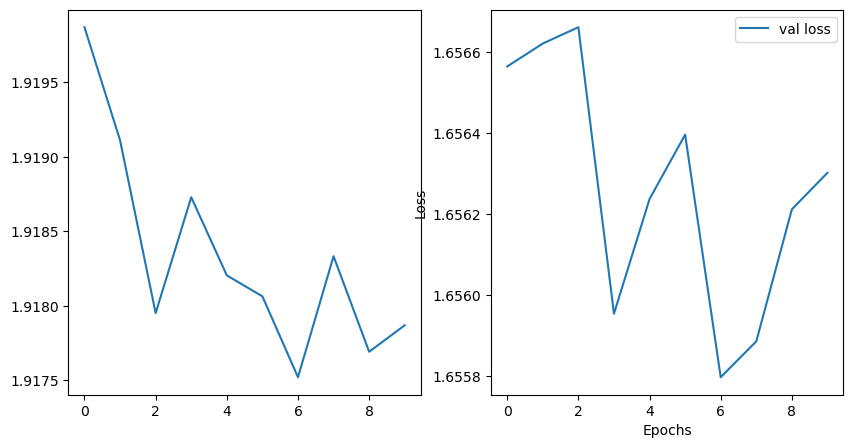

In [41]:
# Plot here
plot_loss(train_losses, val_losses)

In [42]:
# Evaluate
evaluate(val_loader, model_ff)

100%|██████████| 454/454 [00:21<00:00, 21.55it/s]


1.6563021706392587

# Convolution Neural Networks
Now let's try to incorporate the grid sturcture to your model. Instead of passing in vectors, we are going to pass in the 5x5 grid into the model (5lat x 5long x 3channel). You are going to implement you own 2d-convolution neural networks with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Conv2DNN                                 --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
==========================================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read PyTorch documentation to see the list of available layers and options you can use.                         

In [43]:
################################################################################
# TODO#14:                                                                     #
# Complete the code for preparing data for training CNN                        #
# Input for CNN should not have time step.                                     #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class RainfallDatasetCNN(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)).reshape(3, 5, 5)
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

def preprocess_for_cnn(x_train, y_train, x_val, y_val):
    x_train_cnn = x_train.reshape((-1, 3, 5, 5))
    y_train_cnn = y_train.reshape((-1, 1))
    x_val_cnn = x_val.reshape((-1, 3, 5, 5))
    y_val_cnn = y_val.reshape((-1, 1))
    x_test_cnn = x_test.reshape((-1, 3, 5, 5))
    y_test_cnn = y_test.reshape((-1, 1))

    return x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn

In [44]:
x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn = preprocess_for_cnn(x_train, y_train, x_val, y_val)

In [45]:
(x_train_cnn.shape, y_train_cnn.shape), (x_val_cnn.shape, y_val_cnn.shape), (x_test_cnn.shape, y_test_cnn.shape)

(((1147740, 3, 5, 5), (1147740, 1)),
 ((464195, 3, 5, 5), (464195, 1)),
 ((558575, 3, 5, 5), (558575, 1)))

In [46]:
train_dataset_cnn = RainfallDatasetCNN(x_train_cnn, y_train_cnn, normalizer)
val_dataset_cnn = RainfallDatasetCNN(x_val_cnn, y_val_cnn, normalizer)
test_dataset_cnn = RainfallDatasetCNN(x_test_cnn, y_test_cnn, normalizer)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)

(1147740, 3, 5, 5)
(1147740, 1)
(464195, 3, 5, 5)
(464195, 1)
(558575, 3, 5, 5)
(558575, 1)


In [47]:
import torch
################################################################################
# TODO#15:                                                                     #
# Write a PyTorch convolutional neural network model.                          #
# You might want to use the layer torch.flatten somewhere                      #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class FeedForwardCNN(nn.Module):
    def __init__(self,hidden_size=200):
        super(FeedForwardCNN, self).__init__()
        self.conv2d = nn.Conv2d(3, hidden_size, kernel_size=3)
        self.linear1 = nn.Linear(hidden_size * 9, 200)
        self.linear2 = nn.Linear(hidden_size, 200)
        self.linear3 = nn.Linear(hidden_size, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv2d(x)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [48]:
summary(FeedForwardCNN(), input_size=(1024, 3, 5, 5))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardCNN                           [1024, 1]                 --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 461.83
Input size (MB): 0.31
Forward/backward pass size (MB): 18.03
Params size (MB): 1.62
Estimated Total Size (MB): 19.96

In [49]:
################################################################################
# TODO#16:                                                                     #
# Complete the code to train your cnn model                                    #
################################################################################
print('start training conv2d')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


model_ff = FeedForwardCNN(hidden_size=config['hidden_size']).to(device)
train_losses = []
val_losses = []
learning_rates = []

optimizer = torch.optim.Adam(model_ff.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader_cnn)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader_cnn)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(epoch)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff_cnn.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })
wandb.unwatch(model_ff)
wandb.finish()
print('Finished Training')

start training conv2d


Training epoch 1...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:54<00:00, 20.61it/s]


Epoch 1 train loss: 1.9203
Validating epoch 1


100%|██████████| 454/454 [00:20<00:00, 21.81it/s]


Epoch 1 val loss: 1.6578
Saving new best model..
Training epoch 2...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:54<00:00, 20.63it/s]


Epoch 2 train loss: 1.9199
Validating epoch 2


100%|██████████| 454/454 [00:21<00:00, 21.56it/s]


Epoch 2 val loss: 1.6577
Saving new best model..
Training epoch 3...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:54<00:00, 20.74it/s]


Epoch 3 train loss: 1.9189
Validating epoch 3


100%|██████████| 454/454 [00:21<00:00, 21.32it/s]


Epoch 3 val loss: 1.6572
Saving new best model..
Training epoch 4...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:54<00:00, 20.71it/s]


Epoch 4 train loss: 1.9188
Validating epoch 4


100%|██████████| 454/454 [00:21<00:00, 21.52it/s]


Epoch 4 val loss: 1.6572
Training epoch 5...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:53<00:00, 20.92it/s]


Epoch 5 train loss: 1.9187
Validating epoch 5


100%|██████████| 454/454 [00:21<00:00, 21.60it/s]


Epoch 5 val loss: 1.6571
Saving new best model..
Training epoch 6...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:54<00:00, 20.66it/s]


Epoch 6 train loss: 1.9194
Validating epoch 6


100%|██████████| 454/454 [00:20<00:00, 21.95it/s]


Epoch 6 val loss: 1.6577
Training epoch 7...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:53<00:00, 20.95it/s]


Epoch 7 train loss: 1.9190
Validating epoch 7


100%|██████████| 454/454 [00:21<00:00, 21.49it/s]


Epoch 7 val loss: 1.6574
Training epoch 8...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:53<00:00, 21.04it/s]


Epoch 8 train loss: 1.9188
Validating epoch 8


100%|██████████| 454/454 [00:21<00:00, 21.56it/s]


Epoch 8 val loss: 1.6575
Training epoch 9...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:53<00:00, 20.84it/s]


Epoch 9 train loss: 1.9187
Validating epoch 9


100%|██████████| 454/454 [00:21<00:00, 21.62it/s]


Epoch 9 val loss: 1.6577
Training epoch 10...
Current LR: 0.0001


100%|██████████| 1121/1121 [00:53<00:00, 20.86it/s]


Epoch 10 train loss: 1.9187
Validating epoch 10


100%|██████████| 454/454 [00:21<00:00, 21.32it/s]


Epoch 10 val loss: 1.6572


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▂▂▁▄▂▂▁▁
val_loss,█▇▂▂▁▇▄▅▇▂
lr,0.0001
train_loss,1.91872
val_loss,1.65723


Finished Training


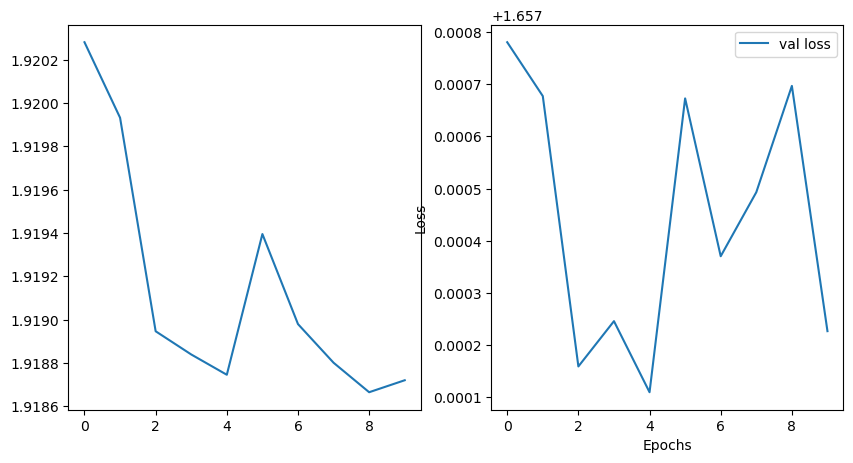

In [50]:
# Plot losses
plot_loss(train_losses, val_losses)

In [51]:
# Evaluate
evaluate(val_loader_cnn, model_ff)

100%|██████████| 454/454 [00:22<00:00, 20.47it/s]


1.6572265022225054

# Gated Recurrent Units

Now, you want to add time steps into your model. Recall the original data has 5 time steps per item. You are going to pass in a data of the form 5 timesteps x 75data. This can be done using a GRU layer. Implement you own GRU network with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
GRUModel                                 --                        --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
==========================================================================================
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
```


These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         
The result should be better than the feedforward model and at least on par with your CNN model.    

Do consult PyTorch documentation on how to use [GRUs](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).


In [52]:
################################################################################
# TODO#17:                                                                     #
# Complete the code for preparing data for training GRU                        #
# GRU's input should has 3 dimensions.                                         #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

def preprocess_for_gru(x_train, y_train, x_val, y_val):
    x_train_gru = x_train.reshape((-1, 5, 3*5*5))
    y_train_gru = y_train.reshape((-1, 5))
    x_val_gru = x_val.reshape((-1, 5, 3*5*5))
    y_val_gru = y_val.reshape((-1, 5))
    x_test_gru = x_test.reshape((-1, 5, 3*5*5))
    y_test_gru = y_test.reshape((-1, 5))

    return x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru

In [58]:
class RainfallDatasetGRU(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index].reshape(5, 75)
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [59]:
x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru = preprocess_for_gru(x_train, y_train, x_val, y_val)

train_dataset_gru = RainfallDatasetGRU(x_train_gru, y_train_gru, normalizer)
val_dataset_gru = RainfallDatasetGRU(x_val_gru, y_val_gru, normalizer)
test_dataset_gru = RainfallDatasetGRU(x_test_gru, y_test_gru, normalizer)

train_loader_gru = DataLoader(train_dataset_gru, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_gru = DataLoader(val_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_gru = DataLoader(test_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)

(229548, 5, 75)
(229548, 5)
(92839, 5, 75)
(92839, 5)
(111715, 5, 75)
(111715, 5)


In [60]:
################################################################################
# TODO#18                                                                      #
# Write a PyTorch GRU model.                                                   #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class FeedForwardGRU(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardGRU, self).__init__()
        self.gru = nn.GRU(input_size=3*5*5, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, 200)
        self.fc2 = nn.Linear(200, 1)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x)
        x = self.fc2(F.relu(x))
        return x

In [61]:
summary(FeedForwardGRU(), input_size=(1024, 5, 3*5*5))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardGRU                           [1024, 5, 1]              --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 892.31
Input size (MB): 1.54
Forward/backward pass size (MB): 16.42
Params size (MB): 0.83
Estimated Total Size (MB): 18.79

In [62]:
################################################################################
# TODO#19                                                                      #
# Complete the code to train your gru model                                    #
################################################################################
print('start training gru')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

model_ff = FeedForwardGRU(hidden_size=config['hidden_size']).to(device)
train_losses = []
val_losses = []
learning_rates = []

optimizer = torch.optim.Adam(model_ff.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)
# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader_gru)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader_gru)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")
        
        # LR adjustment with scheduler
        scheduler.step(epoch)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff_gru.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })
wandb.unwatch(model_ff)
wandb.finish()
print('Finished Training')

start training gru


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training epoch 1...
Current LR: 0.0001


  0%|          | 0/225 [00:00<?, ?it/s]/home/patrick/Workspaces/Study/PatternRecog/.conda/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 5])) that is different to the input size (torch.Size([1024, 5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/225 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (5) must match the size of tensor b (1024) at non-singleton dimension 1

In [ ]:
# Plot
plot_loss(train_losses, val_losses)

In [ ]:
# Evaluate
evaluate(val_loader_gru, model_ff)

# Transformer

Welcome to the beginning of the real world! The aboved models are not usually used in practice due to its limited capability. Transformers are generally used by computer vision, natural language processing, and speech processing (almost every big AI fields).



In our dataloader, we will add the output of this timestep (the number of precipitation) as an auxiliary input to predict the next timestep. Thus, input for the model should be [#batch_size, 5, 76] (5 timesteps and the number 76 comes from (3x5x5)+1) and the output for the model should be [#batch_size, 1] which would be the next timestep we want to predict. Additionally, we will mask the input at the dataloader to the attenttion from observing future values. Suppose that we want to predict timestep 3, we will mask the timestep 3, 4 and 5 in our input by setting it to zeros, and we will predict the timestep 3.

In order to get a score on this TODO, students need to implement a dataloader that mask the input correctly.

In [ ]:
################################################################################
# OT#2:                                                                        #
# Complete the code for preparing data for training Transformer                #
# Transformer's input should has 3 dimensions.                                 #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class RainfallDatasetTransformer(Dataset):
  def __init__(self, x, y, normalizer):
    self.x = x.astype(np.float32)
    self.y = y.astype(np.float32)
    self.normalizer = normalizer
    print(self.x.shape)
    print(self.y.shape)

  def __getitem__(self, index):

    x = self.x[index] # Retrieve data
    # x = self.normalizer.transform(x.reshape(1, -1)).reshape(5, 75)
    x = x.reshape(5,75)
    
    # Add mask input
    mask = np.random.choice([0, 1], size=(5, 1), p=[0.2, 0.8])
    x = np.concatenate((x, mask), axis=-1)
    
    y = self.y[index]
    return x, y

  def __len__(self):
    return self.x.shape[0]

In [ ]:
train_dataset_transformer = RainfallDatasetTransformer(x_train, y_train, normalizer)
val_dataset_transformer = RainfallDatasetTransformer(x_val, y_val, normalizer)
test_dataset_transformer = RainfallDatasetTransformer(x_test, y_test, normalizer)

train_loader_transformer = DataLoader(train_dataset_transformer, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_transformer = DataLoader(val_dataset_transformer, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_transformer = DataLoader(test_dataset_transformer, batch_size=1024, shuffle=False, pin_memory=True)
next(iter(train_loader_transformer))[0].shape

(229548, 5, 5, 5, 3)
(229548, 5)
(92839, 5, 5, 5, 3)
(92839, 5)
(111715, 5, 5, 5, 3)
(111715, 5)


torch.Size([1024, 5, 76])


In this task, we will implement one encoder layer of Transformer and add the linear layer to make a regression prediction. For the simplicity of the model, we will change the multi-head attention to QKV self-attention (single-head). As a result, our model should look like the diagram below. Since the layer self-attention is not availble in torch, students have to implement it themselves. In Add & Norm layer, students have to do the addition before normalizing. In Layer Normalization, we will normalize across both timesteps and features.

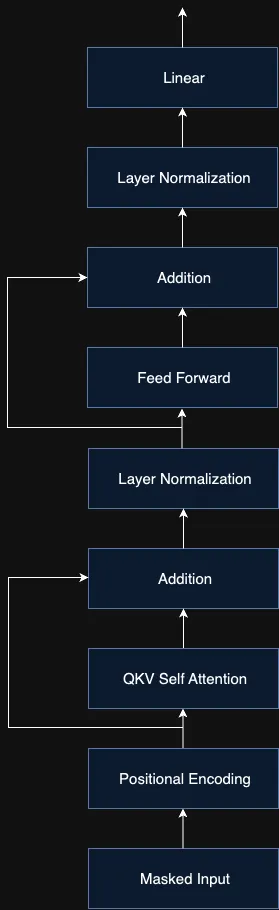

```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
TransformerModel                         [1024, 1]                 --
├─PositionalEncoding: 1-1                [1024, 5, 76]             --
│    └─Dropout: 2-1                  |    [1024, 5, 76]             --
├─SelfAttention: 1-2                     [1024, 5, 76]             --
│    └─Linear: 2-2                       [1024, 5, 76]             5,852
│    └─Linear: 2-3                       [1024, 5, 76]             5,852
│    └─Linear: 2-4                       [1024, 5, 76]             5,852
│    └─Softmax: 2-5                      [1024, 5, 5]              --
├─LayerNorm: 1-3                         [1024, 5, 76]             760
├─Linear: 1-4                            [1024, 5, 76]             5,852
├─LayerNorm: 1-5                         [1024, 5, 76]             760
├─Linear: 1-6                            [1024, 1]                 381
==========================================================================================
Total params: 25,309
Trainable params: 25,309
Non-trainable params: 0
Total mult-adds (M): 25.92
==========================================================================================
Input size (MB): 1.56
Forward/backward pass size (MB): 18.69
Params size (MB): 0.10
Estimated Total Size (MB): 20.34
==========================================================================================
```

In [ ]:
################################################################################
# OT#3                                                                         #
# Write a PyTorch PositionalEncoding model.                                    #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class PositionalEncoding(nn.Module):
  def __init__(self, seq_len, emb_dim, dropout=0.2):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)
    self.pe = torch.zeros(seq_len, emb_dim)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * (-np.log(10000.0) / emb_dim))
    self.pe[:, 0::2] = torch.sin(position * div_term)
    self.pe[:, 1::2] = torch.cos(position * div_term)
    self.pe = self.pe.unsqueeze(0).transpose(0, 1)

  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

In [ ]:
################################################################################
# OT#4                                                                         #
# Write a PyTorch Transformer model.                                           #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.input_dim = input_dim
    self.W_q = nn.Linear(input_dim, input_dim)
    self.W_k = nn.Linear(input_dim, input_dim)
    self.W_v = nn.Linear(input_dim, input_dim)
    self.W_o = nn.Linear(input_dim, input_dim)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)
    attn = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.input_dim)
    attn = self.softmax(attn)
    x = torch.matmul(attn, v)
    x = self.W_o(x)
    return x



class TransformerModel(nn.Module):
  def __init__(self):
    super(TransformerModel, self).__init__()
    self.pe = PositionalEncoding(5, 76)
    self.attn = SelfAttention(75)
    self.layer_norm1 = nn.LayerNorm(76)
    self.fc1 = nn.Linear(76, 5)
    self.layer_norm2 = nn.LayerNorm(5)
    self.fc2 = nn.Linear(5, 1)

  def forward(self, x):
    x_1 = self.pe(x)
    x_2 = self.attn(x_1)
    x_2 = self.layer_norm1(x_2 + x_1)
    x_3 = self.fc1(x_2)
    x_4 = self.layer_norm2(x_3 + x_2)
    x_5 = self.fc2(x_4)
    return x_5


In [ ]:
summary(TransformerModel(), input_size=(1024, 5,76))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [ ]:
################################################################################
# OT#5                                                                         #
# Complete the code to train your Transformer model                                    #
################################################################################
print('start training transformer')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

start training transformer


In [ ]:
# Plot

If you implement it correctly, you should evaluate the model in the test dataset and the score should be better than the aboved models.

In [ ]:
# Evaluate

# Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find printing computation graphs helpful in debugging complicated models.    
Your model should be better than your CNN or GRU model in the previous sections.

Some ideas:

- Tune the hyperparameters
- Adding dropouts
- Combining CNN with GRUs

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [ ]:
# Prep data as you see fit


In [ ]:
################################################################################
# TODO#20                                                                      #
# Write a function that returns your best PyTorch model. You can use anything  #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
################################################################################
# TODO#21                                                                      #
# Complete the code to train your best model                                   #
################################################################################
print('start training the best model')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
# Evaluate best model on validation and test set


In [ ]:
# Also evaluate your fully-connected model and CNN/GRU/Transformer model on the test set.


To get full credit for this part, your best model should be better than the previous models on the **test set**.

### TODO#22

Explain what helped and what did not help here

**Ans:**

# [Optional] Augmentation using data loader

### Optional TODO#6

Implement a new dataloader on your best model that will perform data augmentation. Try adding noise of zero mean and variance of $10e^{-2}$.

Then, train your model.

In [ ]:
# Write Dataset/DataLoader with noise here


In [ ]:
print('start training the best model with noise')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
# Evaluate the best model trained with noise on validation and test set
